In [11]:
import os
import time
import numpy as np
import torch
import torch.nn.functional as F
from torch import optim

from utils.configs import Configs, model_dict
from data_provider.data_factory import data_provider
from utils.tools import EarlyStopping, adjust_learning_rate
from experiments.quantile_calibrator import QuantileCalibrator, pinball_loss, soft_coverage_penalty, compute_PICP, compute_PICP_torch

In [12]:
args = Configs(data='ELC', root_path='/nfs/daojun/Data/TS_Small/')
print("load model ...")
path = os.path.join('./checkpoints/' + args.setting, 'checkpoint.pth')
print(path)
device = torch.device('cuda:0' if args.use_gpu else 'cpu')
model = model_dict[args.model].Model(args).float().to(device)
model.load_state_dict(torch.load(path))
model.eval()

load model ...
./checkpoints/ELC_96_96_iTransformer_custom_S_ft96_sl48_ll96_pl512_dm8_nh2_el1_dl2048_df1_fctimeF_ebTrue_dttest_projection_0/checkpoint.pth


Model(
  (enc_embedding): DataEmbedding_inverted(
    (value_embedding): Linear(in_features=96, out_features=512, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
      (0-1): 2 x EncoderLayer(
        (attention): AttentionLayer(
          (inner_attention): FullAttention(
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (query_projection): Linear(in_features=512, out_features=512, bias=True)
          (key_projection): Linear(in_features=512, out_features=512, bias=True)
          (value_projection): Linear(in_features=512, out_features=512, bias=True)
          (out_projection): Linear(in_features=512, out_features=512, bias=True)
        )
        (conv1): Conv1d(512, 2048, kernel_size=(1,), stride=(1,))
        (conv2): Conv1d(2048, 512, kernel_size=(1,), stride=(1,))
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwi

In [13]:
def _get_qcal_model(taus):
    qcal = QuantileCalibrator(args.seq_len, args.enc_in, args.pred_len, args.c_out, taus, hidden=64, eps_add=0.1, use_covariates=(args.enc_in>1), anchor_tau=0.5)
    return qcal

In [14]:
_, vali_loader = data_provider(args, 'val')
_, train_loader = data_provider(args, 'train')
_, test_loader = data_provider(args, 'test')

val 2537
train 18221
test 5165


In [19]:
def train_quantile_calibrator(taus,
                            lr=1e-3,lambda_cal=1e-2,T_cov=0.5,lambda_mag=1e-4,
                            max_epochs=1,patience=5):
    print('train quantile calibrator ...')
    print("load model ...")
    model.load_state_dict(torch.load(os.path.join('./checkpoints/' + args.setting, 'checkpoint.pth')))
    model.eval().to(device)

    qcal = _get_qcal_model(taus=taus)
    for p in model.parameters(): p.requires_grad=False

    qcal.to(device).train()
    opt=torch.optim.AdamW([p for p in qcal.parameters() if p.requires_grad],
                        lr=lr, weight_decay=1e-4)
    
    path = os.path.join(args.checkpoints, args.setting)
    best=float("inf") 
    bad=0
    best_state=None
    
    for ep in range(max_epochs):
        loss_list=[]
        
        for step, (xb, yb, xb_mark, yb_mark) in enumerate(train_loader):
            with torch.no_grad(): 
                xb = xb.float().to(device)
                yb = yb.float().to(device)
                xb_mark = xb_mark.float().to(device)
                yb_mark = yb_mark.float().to(device)

                f_dim = -1 if args.features == 'MS' else 0
                yb = yb[:, -args.pred_len:, f_dim:].to(device)
                
                yhat = model(xb, xb_mark,  yb, yb_mark)

            qpred=qcal(xb,yhat)
            loss_pred=pinball_loss(yb,qpred,taus)
            loss_cal =soft_coverage_penalty(yb,qpred,taus,T=T_cov)
            reg=sum((p**2).sum() for p in qcal.parameters())
            loss=loss_pred+lambda_cal*loss_cal+lambda_mag*reg
            loss_list.append(loss.item())
            opt.zero_grad(set_to_none=True)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(qcal.parameters(),1.0); opt.step()

            if (step+1) % 100 == 0:
                print({'step': '%d' % (step+1), 'loss': '%.4f' % np.mean(loss_list)})

        # val
        qcal.eval()
        val=0.0; n=0
        with torch.no_grad():
            for step, (xb, yb, xb_mark, yb_mark) in enumerate(vali_loader):
                xb = xb.float().to(device)
                yb = yb.float().to(device)
                xb_mark = xb_mark.float().to(device)
                yb_mark = yb_mark.float().to(device)

                f_dim = -1 if args.features == 'MS' else 0
                yb = yb[:, -args.pred_len:, f_dim:].to(device)
                
                yhat = model(xb,  xb_mark, yb, yb_mark)

                qpred=qcal(xb,yhat)
                
                val += pinball_loss(yb,qpred,taus).item()*xb.size(0)
                n+=xb.size(0)
        val/=max(n,1)
        print('val pinball: %.4f' % val)
        qcal.train()
        if val<best: 
            best, bad = val, 0
            best_state={k:v.cpu() for k,v in qcal.state_dict().items()}
            print('saving qcal to', path + '/' + 'qcal_ckpt_2.pth')
            torch.save(qcal.state_dict(), path + '/' + 'qcal_ckpt_2.pth')
        else: bad +=1
        if bad>=patience: break
    if best_state is not None: qcal.load_state_dict(best_state)

    print("QuantileCalibrator trained. Best val pinball:", best)

    
    qcal.eval()

    # Coverage diagnostic on test:
    with torch.no_grad():
        cov_sum = torch.zeros_like(taus).to(device)
        n_batches=0
        for step, (xb, yb, xb_mark, yb_mark) in enumerate(vali_loader):
            xb = xb.float().to(device)
            yb = yb.float().to(device)
            xb_mark = xb_mark.float().to(device)
            yb_mark = yb_mark.float().to(device)

            f_dim = -1 if args.features == 'MS' else 0
            yb = yb[:, -args.pred_len:, f_dim:].to(device)
            
            yhat = model(xb,  xb_mark, yb, yb_mark)
            
            qpred=qcal(xb,yhat)              # [B,H,m,J]
            y = yb.unsqueeze(-1)             # [B,H,m,1]
            cov = (y <= qpred).float().mean(dim=(0,1,2))   # [J]
            cov_sum += cov
            n_batches += 1
        print("Empirical coverage per tau:", (cov_sum/n_batches).cpu().numpy())

    return qcal, best

In [16]:
def test_quantile_calibrator(taus, qcal=None):
    print('test quantile calibrator ...')
    print("load model ...")
    model.load_state_dict(torch.load(os.path.join('./checkpoints/' + args.setting, 'checkpoint.pth')))
    model.eval().to(device)
    if qcal is None:
        print('load quantile calibrator ...')
        qcal = _get_qcal_model(taus=taus)
        qcal.load_state_dict(torch.load(os.path.join('./checkpoints/' + args.setting, 'qcal_ckpt_2.pth')))
    qcal.eval().to(device)

    picp_list = []

    # Coverage diagnostic on test:
    with torch.no_grad():
        cov_sum = torch.zeros_like(taus).to(device)
        n_batches=0
        for step, (xb, yb, xb_mark, yb_mark) in enumerate(test_loader):
            xb = xb.float().to(device)
            yb = yb.float().to(device)
            xb_mark = xb_mark.float().to(device)
            yb_mark = yb_mark.float().to(device)

            f_dim = -1 if args.features == 'MS' else 0
            yb = yb[:, -args.pred_len:, f_dim:].to(device)
            
            yhat = model(xb,  xb_mark, yb, yb_mark)
            
            qpred=qcal(xb,yhat)              # [B,H,m,J]
            y = yb.unsqueeze(-1)             # [B,H,m,1]
            cov = (y <= qpred).float().mean(dim=(0,1,2))   # [J]
            cov_sum += cov
            n_batches += 1

            pred = qpred[0,:,0,:]
            true = yb[0,:,0]
            # coverage, _, _ = compute_PICP_torch(yb, qpred)
            y_in_range = (true >= pred[:,0]) & (true <= pred[:,1])
            coverage = y_in_range.float().mean()
            picp_list.append(coverage.item())
            #if step>100:break

        print("Empirical coverage per tau= ", (cov_sum/n_batches).cpu().numpy())
        print('mean picp= ', np.mean(picp_list))

In [20]:
taus = torch.tensor([0.025, 0.975], dtype=torch.float32) 
train_quantile_calibrator(taus, max_epochs=5)
test_quantile_calibrator(taus)

train quantile calibrator ...
load model ...


{'step': '100', 'loss': '0.6473'}
{'step': '200', 'loss': '0.6027'}
{'step': '300', 'loss': '0.5644'}
{'step': '400', 'loss': '0.5296'}
{'step': '500', 'loss': '0.4982'}
val pinball: 0.0739
saving qcal to ./checkpoints/ELC_96_96_iTransformer_custom_S_ft96_sl48_ll96_pl512_dm8_nh2_el1_dl2048_df1_fctimeF_ebTrue_dttest_projection_0/qcal_ckpt_2.pth
{'step': '100', 'loss': '0.3038'}
{'step': '200', 'loss': '0.2861'}
{'step': '300', 'loss': '0.2703'}
{'step': '400', 'loss': '0.2563'}
{'step': '500', 'loss': '0.2433'}
val pinball: 0.0740
{'step': '100', 'loss': '0.1625'}
{'step': '200', 'loss': '0.1549'}
{'step': '300', 'loss': '0.1480'}
{'step': '400', 'loss': '0.1421'}
{'step': '500', 'loss': '0.1372'}
val pinball: 0.0739
{'step': '100', 'loss': '0.1038'}
{'step': '200', 'loss': '0.1006'}
{'step': '300', 'loss': '0.0972'}
{'step': '400', 'loss': '0.0949'}
{'step': '500', 'loss': '0.0927'}
val pinball: 0.0737
saving qcal to ./checkpoints/ELC_96_96_iTransformer_custom_S_ft96_sl48_ll96_pl512_dm

In [ ]:
%matplotlib inline  
import matplotlib.pyplot as plt

In [45]:
def vis_sample_with_quan_cali(taus, qcal=None):
    print('test quantile calibrator ...')
    print("load model ...")
    model.load_state_dict(torch.load(os.path.join('./checkpoints/' + args.setting, 'checkpoint.pth')))
    model.eval().to(device)
    if qcal is None:
        print('load quantile calibrator ...')
        qcal = _get_qcal_model(taus=taus)
        qcal.load_state_dict(torch.load(os.path.join('./checkpoints/' + args.setting, 'qcal_ckpt.pth')))
    qcal.eval().to(device)

    picp_list = []

    indexes = np.random.randint(0, len(test_loader), 10)
    print("Randomly selected sample indexes for visualization: ", indexes)
   
    # Coverage diagnostic on test:
    with torch.no_grad():
        cov_sum = torch.zeros_like(taus).to(device)
        n_batches=0
        for step, (xb, yb, xb_mark, yb_mark) in enumerate(test_loader):
            if step not in [0, 908, 3000, 3331, 3800]:
                continue
            xb = xb.float().to(device)
            yb = yb.float().to(device)
            xb_mark = xb_mark.float().to(device)
            yb_mark = yb_mark.float().to(device)

            f_dim = -1 if args.features == 'MS' else 0
            yb = yb[:, -args.pred_len:, f_dim:].to(device)
            
            yhat = model(xb,  xb_mark, yb, yb_mark)
            
            qpred=qcal(xb,yhat)              # [B,H,m,J]
            y = yb.unsqueeze(-1)             # [B,H,m,1]
            cov = (y <= qpred).float().mean(dim=(0,1,2))   # [J]
            cov_sum += cov
            n_batches += 1

            pred = qpred[0,:,0,:]
            true = yb[0,:,0]
            # coverage, _, _ = compute_PICP_torch(yb, qpred)
            y_in_range = (true >= pred[:,0]) & (true <= pred[:,1])
            coverage = y_in_range.float().mean()
            picp_list.append(coverage.item())

            print("Visualizing sample index:", step)
            plt.rcParams.update({"font.size":22})
            plt.figure(figsize=(10,6))
            plt.plot(true.cpu().numpy(), label='Truth', color='blue', linewidth=2)
            plt.plot(yhat[0,:,0].cpu().numpy(), label='Prediction', color='red', linewidth=2)
            plt.fill_between(np.arange(len(true)), pred[:,0].cpu().numpy(), pred[:,1].cpu().numpy(), color='lightcoral', alpha=0.5, label='Calibrated Interval')
            plt.legend()
            plt.title(f'Sample with Quantile Calibration (PICP: {coverage.item():.3f})')
            plt.show()  
            # if step > 10: break
            #if step>100:break

        print("Empirical coverage per tau= ", (cov_sum/n_batches).cpu().numpy())
        print('mean picp= ', np.mean(picp_list))

test quantile calibrator ...
load model ...
load quantile calibrator ...
Randomly selected sample indexes for visualization:  [2246 3270 2063 2021  822 4458 4102 3408 4829 2183]


Visualizing sample index: 0


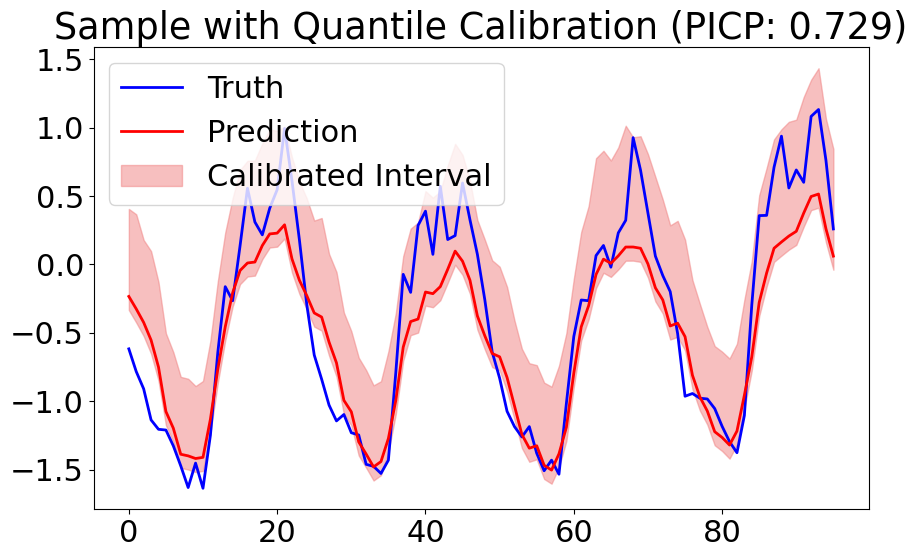

Visualizing sample index: 908


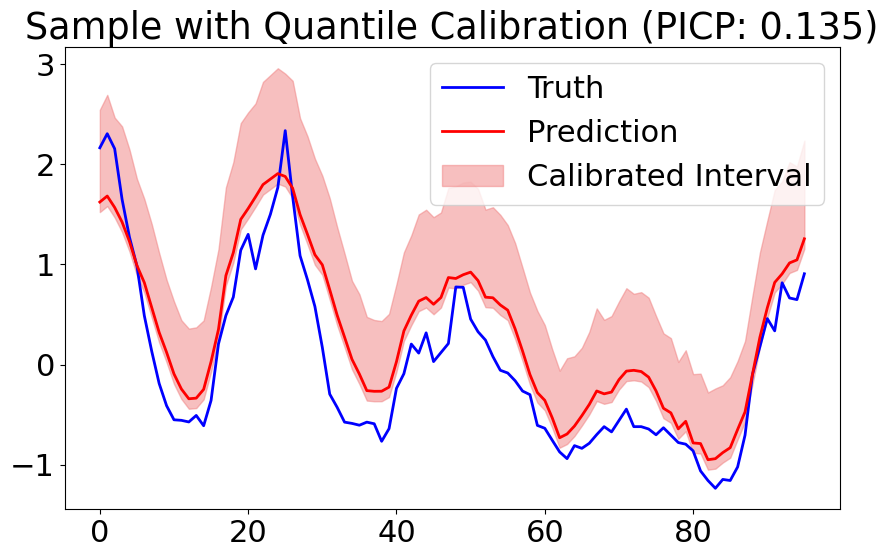

Visualizing sample index: 3000


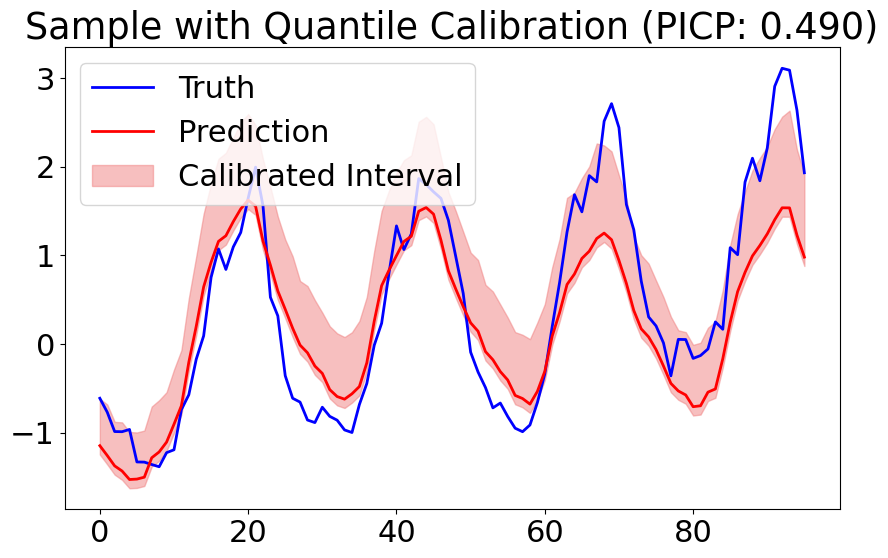

Visualizing sample index: 3331


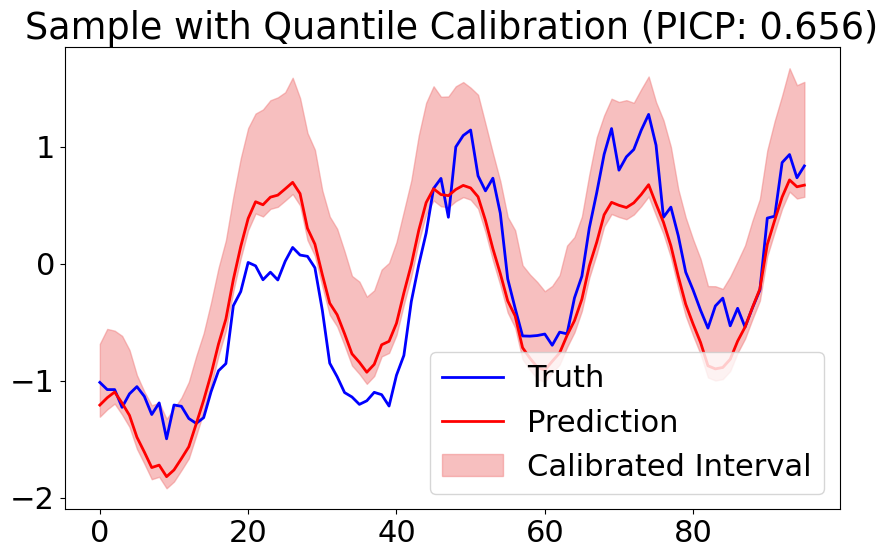

Visualizing sample index: 3800


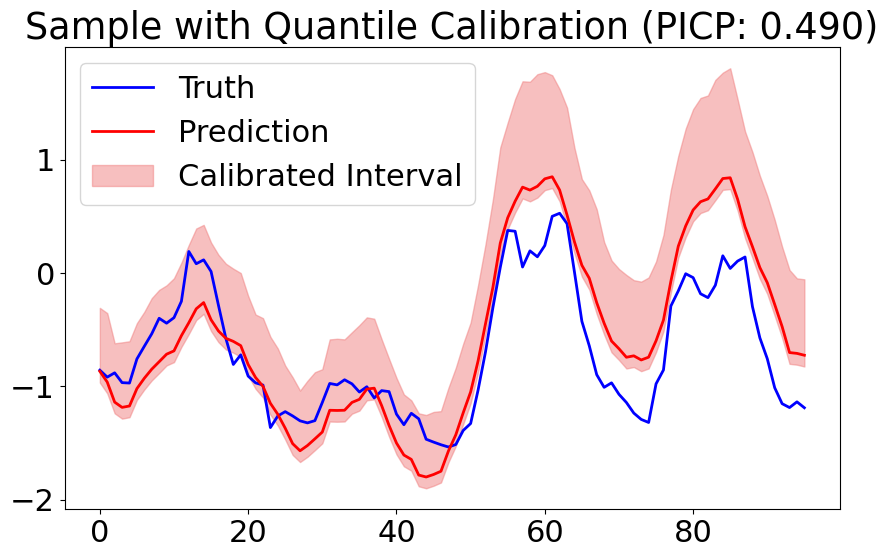

Empirical coverage per tau=  [0.46875 0.96875]
mean picp=  0.5000000089406967


In [46]:
taus = torch.tensor([0.025, 0.975], dtype=torch.float32) 
vis_sample_with_quan_cali(taus)